In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from IPython import display
plt.style.use('seaborn')

In [2]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp
    
def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp
    
def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal
    
def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal
    
def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves
    
def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves
    
def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs
    
def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw
    
def get_ftir_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer2/timestamps'][:]
        return timestamps
    
def get_visible_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer1/timestamps'][:]
        return timestamps
    
def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs
    
def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertion_keys = list(h5_file[calibration_path].keys())
        insertions = [f'{calibration_path}/{key}' for key in insertion_keys]            
        return insertions
    
def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

def construct_full_file_path(data_path, file_name):
    file_path = data_path + file_name
    return file_path

def create_list_of_sessions_in_file(file_name):
    sessions = []
    all_groups = create_list_of_items_in_node("group", file_name, "/")
    for group in all_groups:
        if (group[0:3] == 'ses') and (len(group) == 10):
            sessions.append(group)
    return sessions

def create_list_of_insertions_in_file(file_name):
    insertions = []
    sessions = create_list_of_sessions_in_file(file_name)
    for session in sessions:
        calibrations = create_list_of_calibrations_in_node(file_name, session)
        for calibration in calibrations:
            cal_insertions = create_list_of_insertions_in_calibration(file_name, calibration)
            for insertion in cal_insertions:
                insertions.append(insertion)
    return insertions
            
def get_insertion_timestamp(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_time = h5_file[insertion_path].attrs['start_time']
        ins_timestamp = pd.Timestamp(ins_time, unit='us')
        return ins_timestamp
    
def get_calibration_timestamp(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_time = h5_file[calibration_path].attrs['calibration_start_time']
        cal_timestamp = pd.Timestamp(cal_time, unit='us')
        return cal_timestamp  
    
def find_position_in_wavelength_vector(wavelength_vector, integer):
    position = np.where(np.isclose(wavelength_vector, integer, 1e-3))[0][0]
    return position

def normalize(value, max_value, min_value):
    normalized_value = (value - min_value)/(max_value - min_value)
    return normalized_value

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal
    
def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal
        
def get_ftir_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer2/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp
    
def get_visible_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer1/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp
    
def compute_3D_distance(x1, y1, z1, x2, y2, z2):
    distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    return distance

def calculate_wavenumbers_from_wavelengths(wavelength_vector):
    return 10000000/wavelength_vector

def put_spectrum_in_wavenum_order(spectrum):
    return np.flip(spectrum)

In [3]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
green_list_df = pd.read_csv('data/Green_misc_insertions_210525.csv')
date = '5/25/21'
today_df = green_list_df.loc[green_list_df['date'] == date]

In [4]:
today_df

,file_name,date,session,calibration,insertion,c_unique,i_in_c,i_unique,conditions
106,210525_green_tests/testing_210525.h5,5/25/21,session001,cal001,ins001,c026,i01,c026i01,front yard test
107,210525_green_tests/testing_210525.h5,5/25/21,session001,cal001,ins002,c026,i02,c026i02,front yard test
108,210525_green_tests/testing_210525.h5,5/25/21,session001,cal002,ins003,c027,i01,c027i01,front yard test
109,210525_green_tests/testing_210525.h5,5/25/21,session001,cal002,ins004,c027,i02,c027i02,front yard test
110,210525_green_tests/testing_210525.h5,5/25/21,session001,cal003,ins005,c028,i01,c028i01,front yard test
111,210525_green_tests/testing_210525.h5,5/25/21,session001,cal003,ins006,c028,i02,c028i02,front yard test
112,210525_green_tests/testing_210525.h5,5/25/21,session001,cal004,ins007,c029,i01,c029i01,front yard test
113,210525_green_tests/testing_210525.h5,5/25/21,session001,cal004,ins008,c029,i02,c029i02,front yard test
114,210525_green_tests/testing_210525.h5,5/25/21,session002,cal001,ins001,c030,i01,c030i01,front yard test--later
115,210525_green_tests/testing_210525.h5,5/25/21,session002,cal001,ins002,c030,i02,c030i02,front yard test--later


In [5]:
depth_min = 4.0
depth_max = 35.0

def normalize_depth(depth):
    return (depth - depth_min) / (depth_max - depth_min)

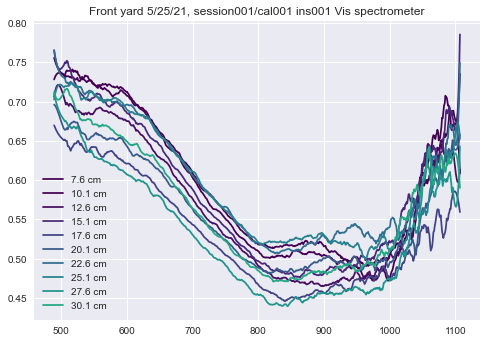

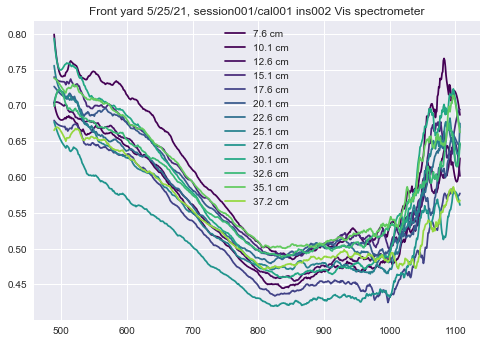

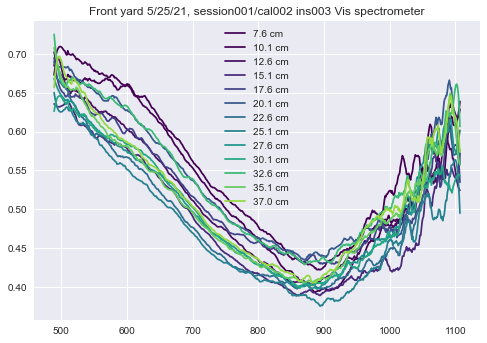

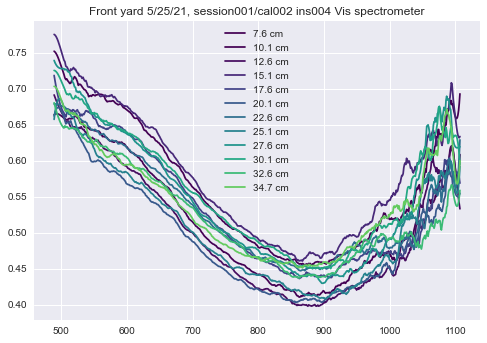

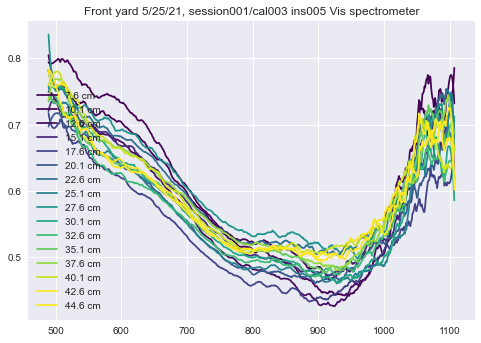

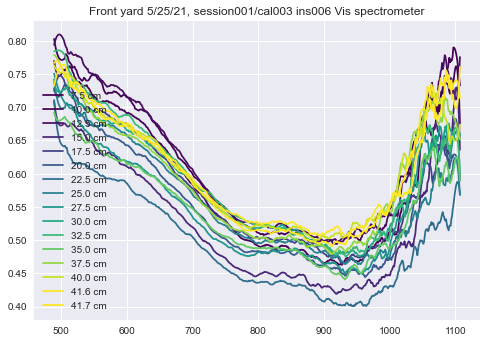

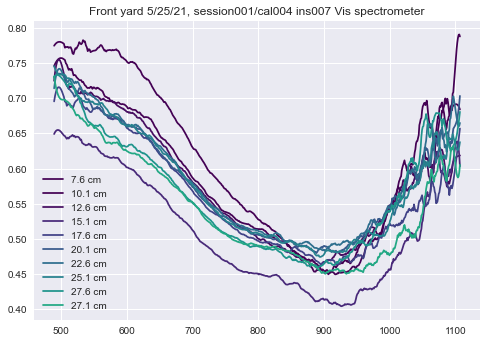

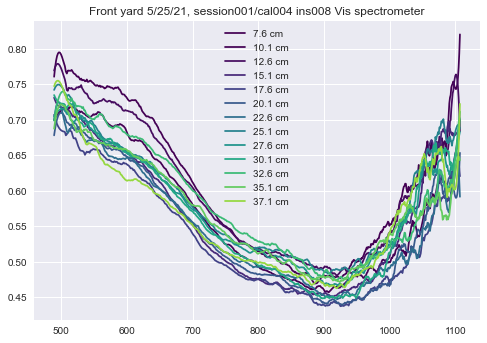

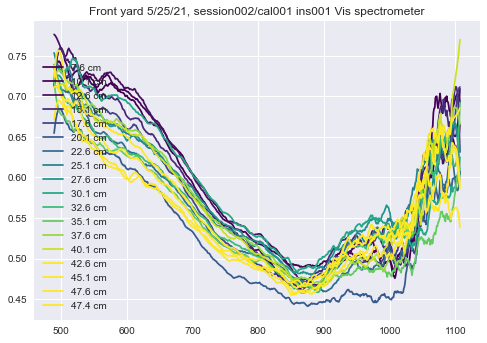

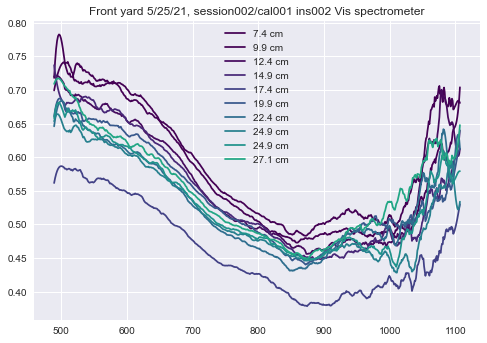

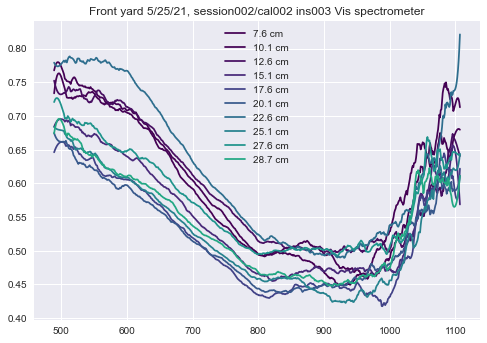

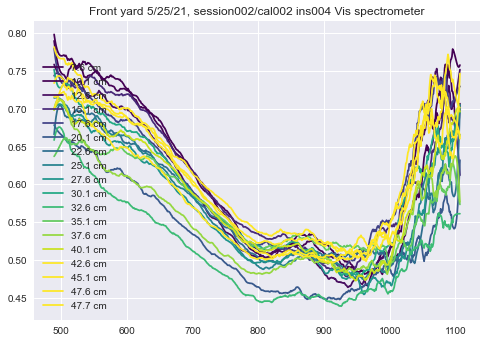

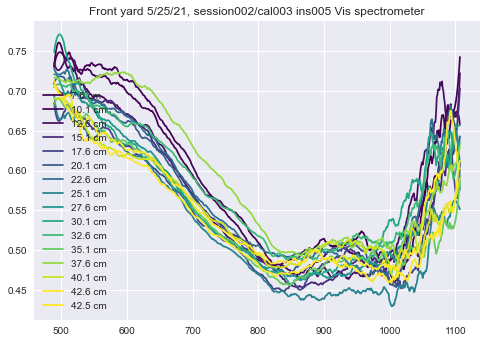

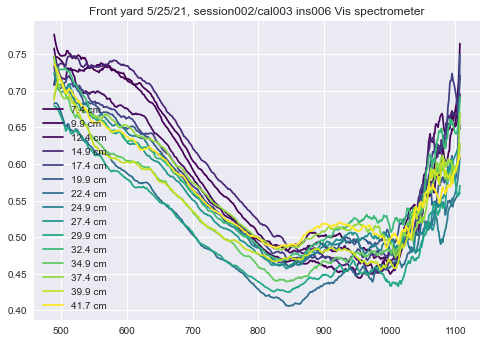

In [6]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = today_df.iat[0, 0]
file = path_name + file_name

for index in today_df.index.values:
    session = today_df['session'][index]
    calibration = today_df['calibration'][index]
    insertion = today_df['insertion'][index]
    cal_path = f'{session}/{calibration}'
    with h5py.File(file, 'r') as h5_file:
        absorbance_depths = h5_file[f'{session}/{calibration}/{insertion}/derived/absorbance_depth'][:]
    waves = get_visible_wavelength_vector(file, cal_path)
    absorbances = absorbance_depths[:, :512]
    depths = absorbance_depths[:, -1]
    absorbances_no_surface = absorbances[depths > 7.0]
    depths_no_surface = depths[depths > 7.0]
    
    fig, ax = plt.subplots()
    ax.set_title(f"Front yard 5/25/21, {cal_path} {insertion} Vis spectrometer")
    for i in range(absorbances_no_surface.shape[0]):
        color = plt.cm.viridis(normalize_depth(depths[i]))
        ax.plot(waves, savgol_filter(absorbances_no_surface[i, :], 21, 3), color=color, label=f'{depths_no_surface[i]:0.1f} cm')
    ax.legend()
    plt.show()
    plt.close()
    

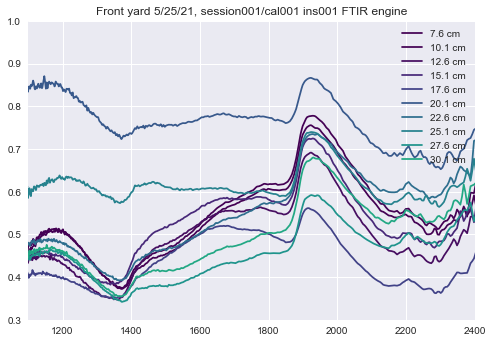

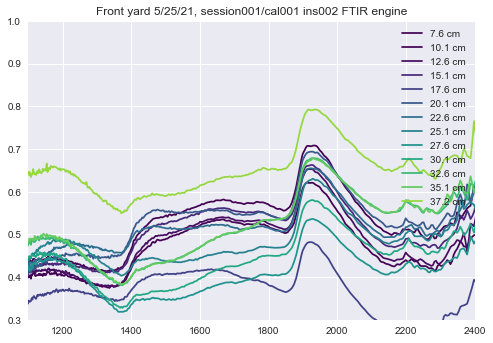

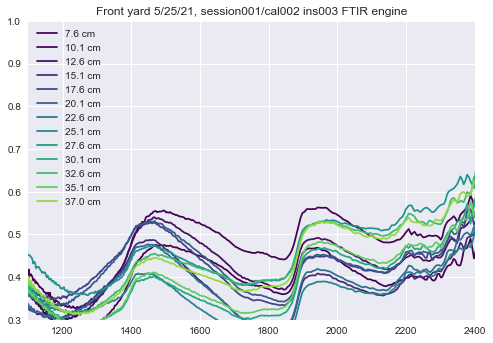

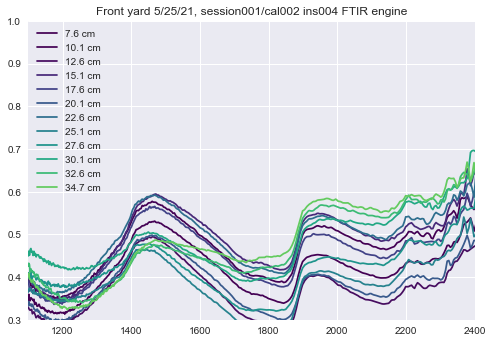

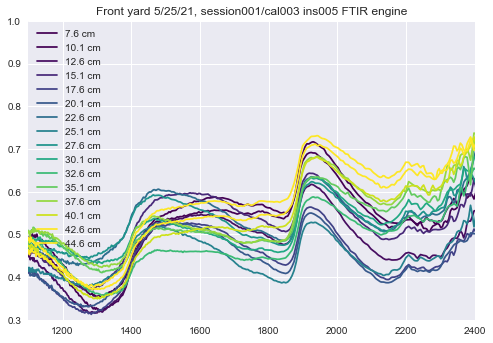

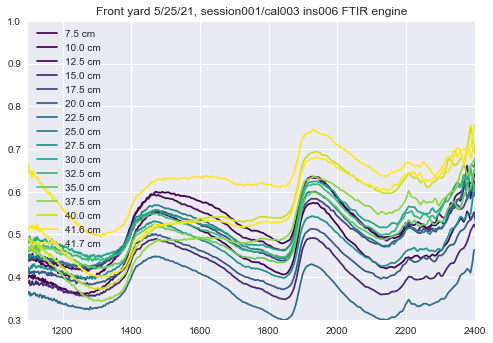

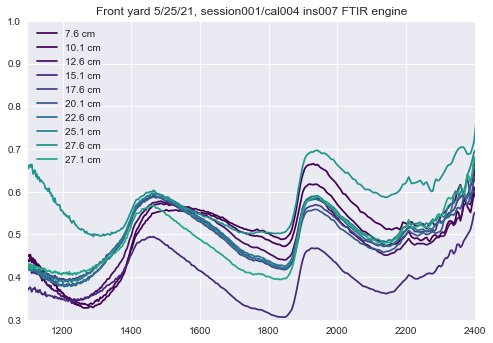

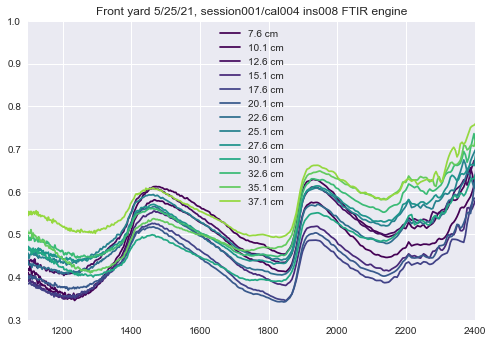

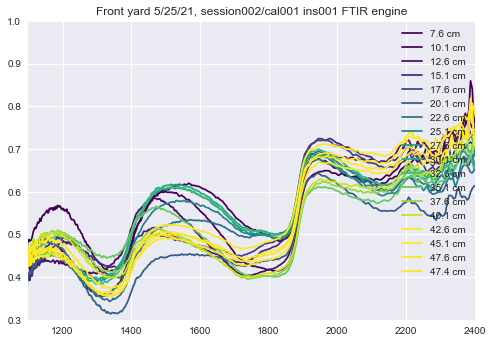

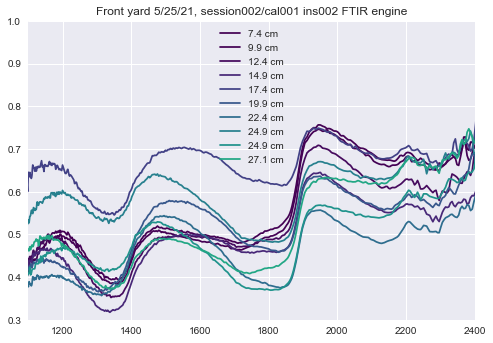

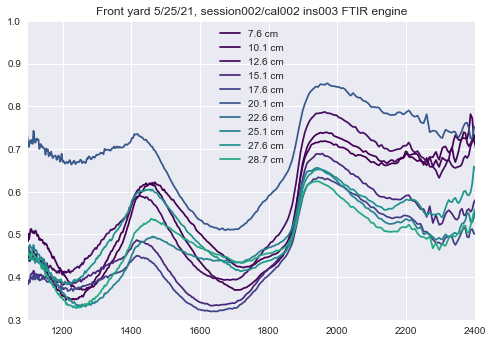

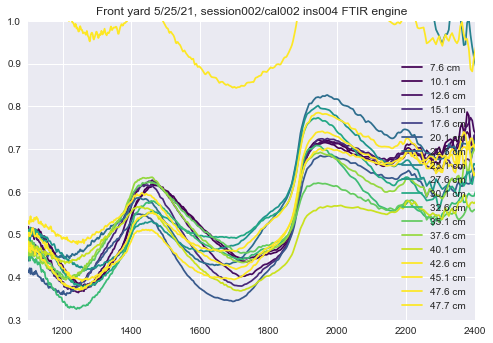

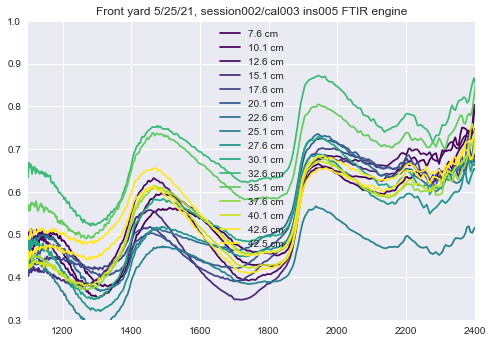

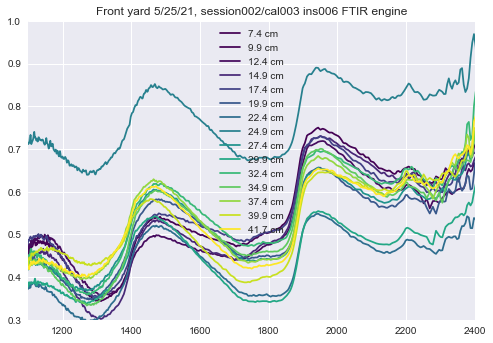

In [7]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = today_df.iat[0, 0]
file = path_name + file_name

for index in today_df.index.values:
    session = today_df['session'][index]
    calibration = today_df['calibration'][index]
    insertion = today_df['insertion'][index]
    cal_path = f'{session}/{calibration}'
    with h5py.File(file, 'r') as h5_file:
        absorbance_depths = h5_file[f'{session}/{calibration}/{insertion}/derived/absorbance_depth'][:]
    waves = get_ftir_wavelength_vector(file, cal_path)
    absorbances = absorbance_depths[:, 512:-2]
    depths = absorbance_depths[:, -1]
    absorbances_no_surface = absorbances[depths > 7.0]
    depths_no_surface = depths[depths > 7.0]
    
    fig, ax = plt.subplots()
    ax.set_title(f"Front yard 5/25/21, {cal_path} {insertion} FTIR engine")
    ax.set_xlim(1100, 2400)
    ax.set_ylim(0.3, 1.0)
    for i in range(absorbances_no_surface.shape[0]):
        color = plt.cm.viridis(normalize_depth(depths[i]))
        ax.plot(waves, absorbances_no_surface[i, :], color=color, label=f'{depths_no_surface[i]:0.1f} cm')
    ax.legend()
    plt.show()
    plt.close()

In [8]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = today_df.iat[0, 0]
file = path_name + file_name

columns = list(range(0, 1213, 1))
columns.append('depth')

all_df = pd.DataFrame()

for index in today_df.index.values:
    session = today_df['session'][index]
    calibration = today_df['calibration'][index]
    insertion = today_df['insertion'][index]
    cal_path = f'{session}/{calibration}'
    with h5py.File(file, 'r') as h5_file:
        absorbance_depths = h5_file[f'{session}/{calibration}/{insertion}/derived/absorbance_depth'][:]
    insertion_df = pd.DataFrame(data=absorbance_depths, columns=columns)
    insertion_df['cal_path'] = cal_path
    insertion_df['insertion'] = insertion
    
    all_df = pd.concat([all_df, insertion_df], ignore_index=True)
    
print(all_df.shape)

(232, 1216)


In [9]:
all_df['depth']

0       0.093421
1       2.594051
2       5.094630
3       7.594701
4      10.094822
         ...    
227    32.438541
228    34.938257
229    37.437820
230    39.937842
231    41.696078
Name: depth, Length: 232, dtype: float64

In [10]:
ten_twenty = all_df.loc[(all_df['depth'] > 10.0) & (all_df['depth'] < 20.0)]

In [11]:
ten_twenty

,0,1,2,3,4,5,6,7,8,9,...,1206,1207,1208,1209,1210,1211,1212,depth,cal_path,insertion
4,0.738667,0.771068,0.745565,0.752043,0.743374,0.726830,0.751382,0.729678,0.749066,0.730314,...,0.218389,0.548447,0.496037,0.228335,0.210217,0.273815,317997.0,10.094822,session001/cal001,ins001
5,0.699969,0.689008,0.751476,0.729213,0.715590,0.746176,0.709293,0.702231,0.713013,0.710938,...,0.202417,0.209924,0.156912,0.073747,0.018155,-0.030470,486791.0,12.594792,session001/cal001,ins001
6,0.791445,0.722927,0.775435,0.731536,0.703838,0.757630,0.757409,0.725341,0.761174,0.748439,...,0.427503,0.158148,0.177207,0.391578,0.313655,0.136687,472883.0,15.094609,session001/cal001,ins001
7,0.691154,0.657546,0.675669,0.610027,0.668394,0.645701,0.646746,0.694124,0.654818,0.668469,...,0.335957,0.273870,0.234198,0.203050,0.093337,-0.029043,485453.0,17.594630,session001/cal001,ins001
17,0.701847,0.672556,0.729241,0.669160,0.697444,0.658213,0.710967,0.668772,0.713013,0.664904,...,0.184732,0.037725,0.028469,0.103945,-0.053980,-0.247552,286111.0,10.062818,session001/cal001,ins002
18,0.720604,0.721948,0.663755,0.663150,0.723156,0.721457,0.718158,0.707584,0.720402,0.681923,...,0.487522,0.349852,0.224037,0.108084,0.153881,0.315410,309263.0,12.562891,session001/cal001,ins002
19,0.734080,0.714196,0.789821,0.739054,0.698291,0.757147,0.740472,0.696136,0.727498,0.714505,...,0.281651,0.313973,0.155764,-0.045643,-0.051360,0.027725,356411.0,15.062859,session001/cal001,ins002
20,0.705629,0.635762,0.707640,0.622530,0.689478,0.695128,0.658109,0.669531,0.703751,0.655420,...,0.396482,0.405455,0.268077,0.091411,0.045832,0.043073,357606.0,17.562727,session001/cal001,ins002
33,0.703712,0.651487,0.689471,0.768167,0.680405,0.717555,0.689562,0.709378,0.719852,0.692731,...,0.085430,0.047522,0.131812,0.291598,0.316546,0.256705,251070.0,10.096956,session001/cal002,ins003
34,0.689356,0.645137,0.693678,0.725262,0.671412,0.713394,0.657569,0.722081,0.679527,0.678757,...,0.155590,0.034215,0.066838,0.180773,0.222722,0.245118,331993.0,12.597028,session001/cal002,ins003


In [12]:
ten_twelve = all_df.loc[(all_df['depth'] > 10.0) & (all_df['depth'] < 12.0)]

In [13]:
ten_twelve

,0,1,2,3,4,5,6,7,8,9,...,1206,1207,1208,1209,1210,1211,1212,depth,cal_path,insertion
4,0.738667,0.771068,0.745565,0.752043,0.743374,0.726830,0.751382,0.729678,0.749066,0.730314,...,0.218389,0.548447,0.496037,0.228335,0.210217,0.273815,317997.0,10.094822,session001/cal001,ins001
17,0.701847,0.672556,0.729241,0.669160,0.697444,0.658213,0.710967,0.668772,0.713013,0.664904,...,0.184732,0.037725,0.028469,0.103945,-0.053980,-0.247552,286111.0,10.062818,session001/cal001,ins002
33,0.703712,0.651487,0.689471,0.768167,0.680405,0.717555,0.689562,0.709378,0.719852,0.692731,...,0.085430,0.047522,0.131812,0.291598,0.316546,0.256705,251070.0,10.096956,session001/cal002,ins003
49,0.671377,0.655773,0.656777,0.669450,0.674816,0.642238,0.669597,0.686260,0.657626,0.663697,...,0.252788,0.152586,0.235758,0.451050,0.470445,0.348102,402338.0,10.072624,session001/cal002,ins004
64,0.821658,0.784472,0.770374,0.809258,0.755261,0.754212,0.740268,0.814110,0.756762,0.739309,...,0.087374,-0.245079,-0.237268,-0.018812,0.119835,0.225457,276943.0,10.096549,session001/cal003,ins005
83,0.803716,0.840782,0.763841,0.755992,0.716829,0.790376,0.787761,0.777580,0.754985,0.827080,...,0.321829,0.129312,0.164874,0.370019,0.254159,0.048139,299398.0,10.005516,session001/cal003,ins006
102,0.755930,0.725790,0.761602,0.737768,0.754115,0.800650,0.763702,0.773115,0.697544,0.743752,...,0.336095,0.148091,0.025879,-0.058083,0.090035,0.325814,322655.0,10.096397,session001/cal004,ins007
115,0.679600,0.699452,0.748135,0.709913,0.673229,0.736300,0.729763,0.700600,0.689083,0.726163,...,0.405741,0.390724,0.242322,0.014654,0.109957,0.335716,322560.0,10.077042,session001/cal004,ins008
131,0.681176,0.789891,0.734641,0.739330,0.743233,0.750100,0.737742,0.742401,0.751180,0.775168,...,0.396261,0.489727,0.337204,-0.053202,-0.162105,-0.085617,254238.0,10.097770,session002/cal001,ins001
165,0.728321,0.785250,0.812763,0.799911,0.786773,0.755134,0.745692,0.821159,0.787327,0.757148,...,0.901656,0.513316,0.395185,0.530406,0.627781,0.504427,314040.0,10.096397,session002/cal002,ins003


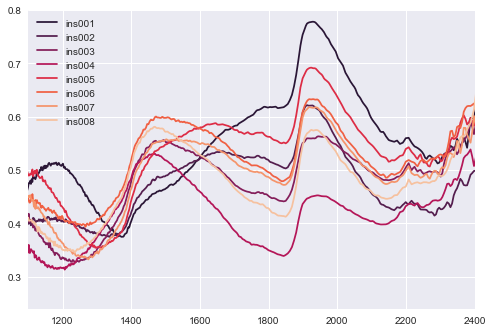

In [14]:
early = ten_twelve.iloc[:8, :]
insertions = early['insertion'].unique()
rgb_values = sns.color_palette("rocket", 8)
color_map = dict(zip(insertions, rgb_values))
fig, ax = plt.subplots()
ax.set_xlim(1100, 2400)
ax.set_ylim(0.24, 0.8)
for i in range(early.shape[0]):
    color = list(early['insertion'].map(color_map))[i]
    ax.plot(waves, early.iloc[i, 512:-4], color=color, label=early.iat[i, -1])
ax.legend()

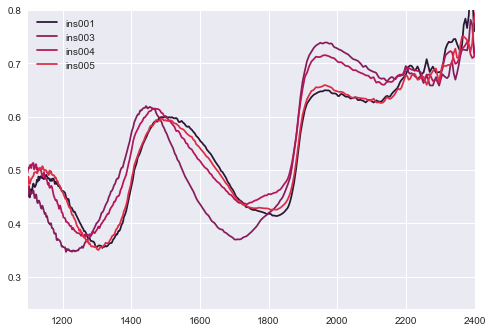

In [16]:
late = ten_twelve.iloc[8:, :]
insertions = early['insertion'].unique()
rgb_values = sns.color_palette("rocket", 8)
color_map = dict(zip(insertions, rgb_values))
fig, ax = plt.subplots()
ax.set_xlim(1100, 2400)
ax.set_ylim(0.24, 0.8)
for i in range(late.shape[0]):
    color = list(late['insertion'].map(color_map))[i]
    ax.plot(waves, late.iloc[i, 512:-4], color=color, label=late.iat[i, -1])
ax.legend()

In [17]:
twenty_22 = all_df.loc[(all_df['depth'] > 20.0) & (all_df['depth'] < 22.0)]

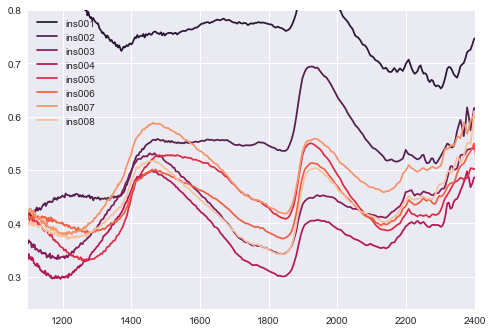

In [18]:
early = twenty_22.iloc[:8, :]
insertions = early['insertion'].unique()
rgb_values = sns.color_palette("rocket", 8)
color_map = dict(zip(insertions, rgb_values))
fig, ax = plt.subplots()
ax.set_xlim(1100, 2400)
ax.set_ylim(0.24, 0.8)
for i in range(early.shape[0]):
    color = list(early['insertion'].map(color_map))[i]
    ax.plot(waves, early.iloc[i, 512:-4], color=color, label=early.iat[i, -1])
ax.legend()

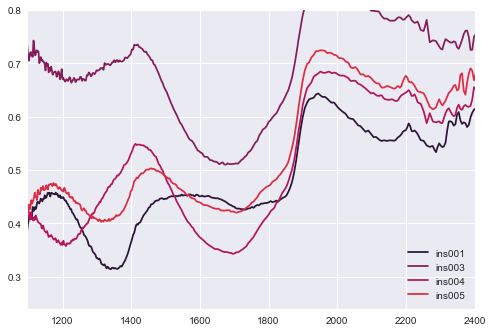

In [19]:
late = twenty_22.iloc[8:, :]
insertions = early['insertion'].unique()
rgb_values = sns.color_palette("rocket", 8)
color_map = dict(zip(insertions, rgb_values))
fig, ax = plt.subplots()
ax.set_xlim(1100, 2400)
ax.set_ylim(0.24, 0.8)
for i in range(late.shape[0]):
    color = list(late['insertion'].map(color_map))[i]
    ax.plot(waves, late.iloc[i, 512:-4], color=color, label=late.iat[i, -1])
ax.legend()